<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/A1_MAE_%E0%B8%A3%E0%B8%AD%E0%B8%9A%E0%B8%97%E0%B8%B5%E0%B9%881_Train_Male125_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [21]:
import pandas as pd
import shutil

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/Data_Male_125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07M,VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
1,2,1,7,Y07M,Flip_VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
2,3,2,7,Y07M,VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
3,4,2,7,Y07M,Flip_VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
4,5,3,7,Y07M,VV05.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
...,...,...,...,...,...,...,...,...
2370,121,77,25,Y25M,Flip_J463.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both
2371,122,78,25,Y25M,J464.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both
2372,123,78,25,Y25M,Flip_J464.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both
2373,124,79,25,Y25M,J465.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both


#Imports

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [26]:
batch_size = 16
width = 150
height = 150
epochs = 100
NUM_TRAIN = 1425
NUM_TEST = 473
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [27]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [28]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [29]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [30]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(19, activation='softmax', name="fc_out"))
model.add(layers.Dense(1))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
 dense_1 (Dense)             (None, 1)                 20        
                                                                 
Total params: 4,073,923
Trainable params: 4,031,907
Non-trainable params: 42,016
_______________________________________

In [32]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 215
This is the number of trainable layers after freezing the conv base: 4


In [33]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 75, 75, 32)  128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [34]:
base_dir = '/content/drive/MyDrive/TVT_Male125'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)


#Train

In [35]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1425 images belonging to 19 classes.
Found 475 images belonging to 19 classes.


In [36]:
model.compile(loss='mse',
          optimizer=Adam(lr=2e-5),
          metrics=['mae'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-36-d85b56dbbd20>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
89/89 [==============================] - 23s 196ms/step - loss: 0.0784 - mae: 0.1927 - val_loss: 0.0583 - val_mae: 0.1606
Epoch 2/100
89/89 [==============================] - 17s 186ms/step - loss: 0.0609 - mae: 0.1394 - val_loss: 0.0557 - val_mae: 0.1561
Epoch 3/100
89/89 [==============================] - 16s 178ms/step - loss: 0.0558 - mae: 0.1264 - val_loss: 0.0540 - val_mae: 0.1468
Epoch 4/100
89/89 [==============================] - 17s 180ms/step - loss: 0.0537 - mae: 0.1177 - val_loss: 0.0518 - val_mae: 0.1317
Epoch 5/100
89/89 [==============================] - 17s 182ms/step - loss: 0.0516 - mae: 0.1099 - val_loss: 0.0500 - val_mae: 0.1053
Epoch 6/100
89/89 [==============================] - 17s 180ms/step - loss: 0.0507 - mae: 0.1029 - val_loss: 0.0499 - val_mae: 0.0975
Epoch 7/100
89/89 [==============================] - 17s 178ms/step - loss: 0.0503 - mae: 0.0997 - val_loss: 0.0499 - val_mae: 0.0969
Epoch 8/100
89/89 [==============================] - 17s 179ms

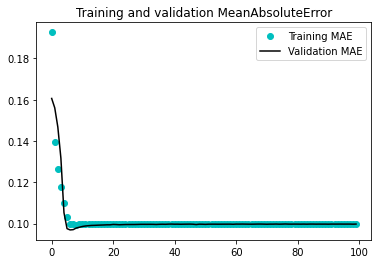

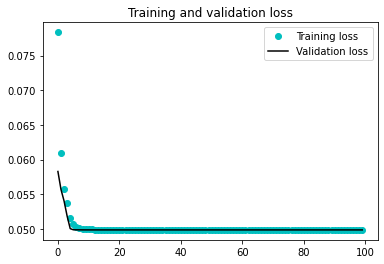

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


epochs_x = range(len(loss))


plt.plot(epochs_x, mae, 'co', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and validation MeanAbsoluteError')
plt.legend()

plt.figure()
plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
epochs_x

range(0, 100)

#Download the model


In [39]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/MAE_1.1_รอบแรก_Flimpano_Male125_100.h5')

In [40]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1.1_รอบแรก_Flimpano_Male125_250.h5')